In [129]:
import pandas as pd
import numpy as np 
import json

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates

import seaborn as sns
import plotly.express as px
import geopandas as gpd
from shapely.geometry import Point
import plotly.express as px


In [159]:
# Some default plotting params
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['font.size'] = 18  # Set default font size for text
mpl.rcParams['axes.labelsize'] = 12  # Font size for x and y labels
mpl.rcParams['axes.titlesize'] = 18  # Font size for title
mpl.rcParams['xtick.labelsize'] = 8  # Font size for x-axis tick labels
mpl.rcParams['ytick.labelsize'] = 12  # Font size for y-axis tick labels
mpl.rcParams['legend.fontsize'] = 8  # Font size for legend

# Truck Data 2016 - 2023
    AADT: anual average dailey traffic


In [87]:
raw_dat = pd.read_csv("/Users/zoelye/Documents/Brainstation/capstone/Data_traffic/aadt_and_truckpct.csv")

/var/folders/nx/f6nvx6t92s11crn09q_ggcpc0000gn/T/ipykernel_28831/3631192900.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_dat = pd.read_csv("/Users/zoelye/Documents/Brainstation/capstone/Data_traffic/aadt_and_truckpct.csv")


In [155]:
# subset for new york and surrounding counties 
city_dat = raw_dat[raw_dat['County'].isin(['Bronx','Kings', 'New york','Queens', 'Richmond', 'Westchester', 'Nassau'])]

In [157]:
city_dat.columns
# data from 2016

Index(['Station ID', 'Station Name', 'Description', 'County', 'Route',
       'From Milepoint', 'To Milepoint', 'Functional Class', 'Latitude',
       'Longitude', 'AADT_2023', 'AAWDT_2023', 'Truck%_2023', 'AADT_2022',
       'AAWDT_2022', 'Truck%_2022', 'AADT_2021', 'AAWDT_2021', 'Truck%_2021',
       'AADT_2020', 'AAWDT_2020', 'Truck%_2020', 'AADT_2019', 'AAWDT_2019',
       'Truck%_2019', 'AADT_2018', 'AAWDT_2018', 'Truck%_2018', 'AADT_2017',
       'AAWDT_2017', 'Truck%_2017', 'AADT_2016', 'AAWDT_2016', 'Truck%_2016'],
      dtype='object')

In [56]:
city_dat.isna().any(axis=1).sum()

13710

In [95]:
# how much data missing from 2023 to 2020 
total_nan = city_dat[['AADT_2023', 'AAWDT_2023', 'Truck%_2023', 'AADT_2022',
       'AAWDT_2022', 'Truck%_2022', 'AADT_2021', 'AAWDT_2021', 'Truck%_2021',
       'AADT_2020', 'AAWDT_2020', 'Truck%_2020']].isna().sum()

print(total_nan)

AADT_2023       1020
AAWDT_2023     13706
Truck%_2023     3208
AADT_2022       2005
AAWDT_2022     13704
Truck%_2022     3568
AADT_2021       2263
AAWDT_2021     13701
Truck%_2021     3976
AADT_2020       2246
AAWDT_2020     11404
Truck%_2020     4155
dtype: int64


In [203]:
city_dat.value_counts('County')

County
Nassau         4152
Westchester    3142
Queens         2181
Kings          1384
Bronx          1143
New york        939
Richmond        772
Name: count, dtype: int64

In [205]:
# get long data
city_l = pd.melt(city_dat, 
                    id_vars=['Station ID', 'Station Name', 'Description', 'County', 'Route',
                             'From Milepoint', 'To Milepoint', 'Functional Class', 'Latitude',
                             'Longitude'],
                    var_name='Measurement_Year', value_name='Value')

# Extract the year and measurement type
city_l['Year'] = city_l['Measurement_Year'].str.extract(r'(\d{4})')
city_l['Measurement_Type'] = city_l['Measurement_Year'].str.extract(r'([A-Za-z%]+)')
# Drop the original Measurement_Year column
city_l = city_l.drop(columns=['Measurement_Year'])

In [207]:
city_l['County'].value_counts()

County
Nassau         99648
Westchester    75408
Queens         52344
Kings          33216
Bronx          27432
New york       22536
Richmond       18528
Name: count, dtype: int64

In [134]:
# Pivot the DataFrame to get separate columns for AADT, AAWDT, and Truck%
city_pivot = city_l.pivot_table(index=['Station ID', 'Station Name', 'Description', 'County', 'Route',
                                        'From Milepoint', 'To Milepoint', 'Functional Class', 'Latitude',
                                        'Longitude', 'Year'],
                                 columns='Measurement_Type', values='Value').reset_index()

In [165]:
city_l.head()
print("long shape", city_l.shape)
city_l_clean = city_l.dropna(subset=['Value'])
print("cleaned long shape", city_l_clean.shape)
# lots of mission data

long shape (329112, 13)
cleaned long shape (187252, 13)


In [181]:
# Group by year_month and category, and count observations
year_counts = city_l.groupby(['Year', 'County', 'Functional Class']).size().unstack(fill_value=0).reset_index()
year_counts.head()

Functional Class,Year,County,:Local,:Major Collector,:Principal Arterial - Freeways & Expressways,:Principal Arterial - Interstate,:Principal Arterial - Other,LU:Principal Arterial - Freeways & Expressways,Rural:Principal Arterial - Interstate,Urban:Local,Urban:Major Collector,Urban:Minor Arterial,Urban:Principal Arterial - Freeways & Expressways,Urban:Principal Arterial - Interstate,Urban:Principal Arterial - Other
0,2016,Bronx,6,3,6,6,0,0,0,720,804,462,318,540,546
1,2016,Kings,3,0,0,3,0,0,0,945,972,882,279,183,885
2,2016,Nassau,0,0,0,0,0,0,0,4950,2949,2115,1491,282,654
3,2016,New york,0,0,0,6,6,0,0,192,714,825,366,159,543
4,2016,Queens,0,0,0,0,6,0,0,2070,1218,783,681,816,957


<Figure size 1000x600 with 0 Axes>

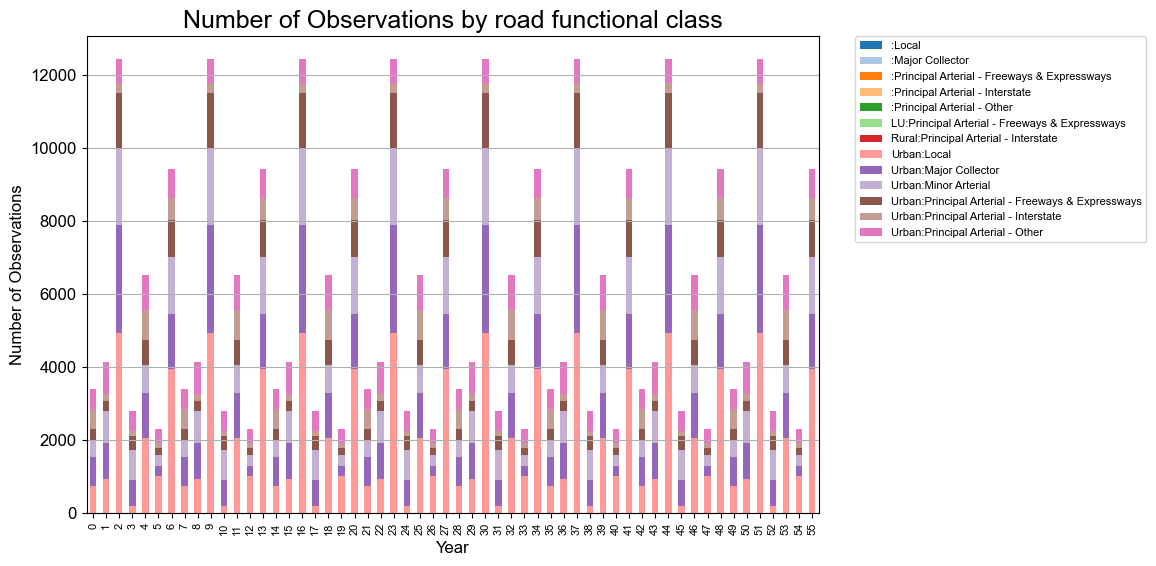

In [185]:
# PLOT TYPES OF ROAD WAY PER COUNTY
plt.figure(figsize=(10, 6))
# Set Seaborn color palette
palette = sns.color_palette("tab20")
# Plot stacked bar chart
year_counts.plot(kind='bar', stacked=True, color=palette.as_hex(), figsize=(12, 6))
plt.title('Number of Observations by road functional class')
plt.xlabel('Year')
plt.ylabel('Number of Observations')
plt.grid(False)

# Save the figure as a JPEG file
#plt.savefig('monthly_observation_counts_by_boro.jpeg', format='jpeg', dpi=300)

plt.legend(title='Road types')
plt.grid(True, axis='y')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

_____
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame structure
data = {
    'year': [2021, 2021, 2021, 2022, 2022, 2022, 2023, 2023, 2023],
    'county': ['County1', 'County2', 'County1', 'County1', 'County2', 'County2', 'County1', 'County2', 'County3'],
    'borough': ['Borough1', 'Borough1', 'Borough2', 'Borough1', 'Borough2', 'Borough2', 'Borough1', 'Borough3', 'Borough3'],
    'road_type': ['Type1', 'Type2', 'Type1', 'Type3', 'Type1', 'Type2', 'Type3', 'Type1', 'Type3'],
    'observations': [100, 150, 200, 250, 100, 150, 300, 200, 100]
}

df = pd.DataFrame(data)

# Group by year, county, and borough, and sum the observations
year_counts = df.groupby(['year', 'county', 'borough', 'road_type']).sum().unstack().fillna(0)

# Flatten the MultiIndex for columns
year_counts.columns = ['_'.join(col).strip() for col in year_counts.columns.values]

# Ensure 'year' is treated as a categorical variable
year_counts.index = year_counts.index.astype(str)  # Convert year index to string for proper labeling

# Set the figure size
plt.figure(figsize=(12, 6))

# Set Seaborn color palette
palette = sns.color_palette("tab20")

# Plot stacked bar chart
year_counts.plot(kind='bar', stacked=True, color=palette.as_hex(), figsize=(12, 6))

# Set title and labels
plt.title('Number of Observations by Road Functional Class, County, and Borough')
plt.xlabel('Year')
plt.ylabel('Number of Observations')

# Add a legend with title
plt.legend(title='Borough', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set grid for y-axis
plt.grid(True, axis='y')

# Ensure correct labeling for the x-axis
plt.xticks(rotation=0)  # Ensure year labels are horizontal

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



In [197]:
class_cts = city_l.groupby(['Year', 'County', 'Functional Class'], as_index=False).size()
class_cts.head(2)

,Year,County,Functional Class,size
0,2016,Bronx,:Local,6
1,2016,Bronx,:Major Collector,3


/var/folders/nx/f6nvx6t92s11crn09q_ggcpc0000gn/T/ipykernel_28831/982575690.py:8: UserWarning: The palette list has more values (20) than needed (13), which may not be intended.
  sns.barplot(


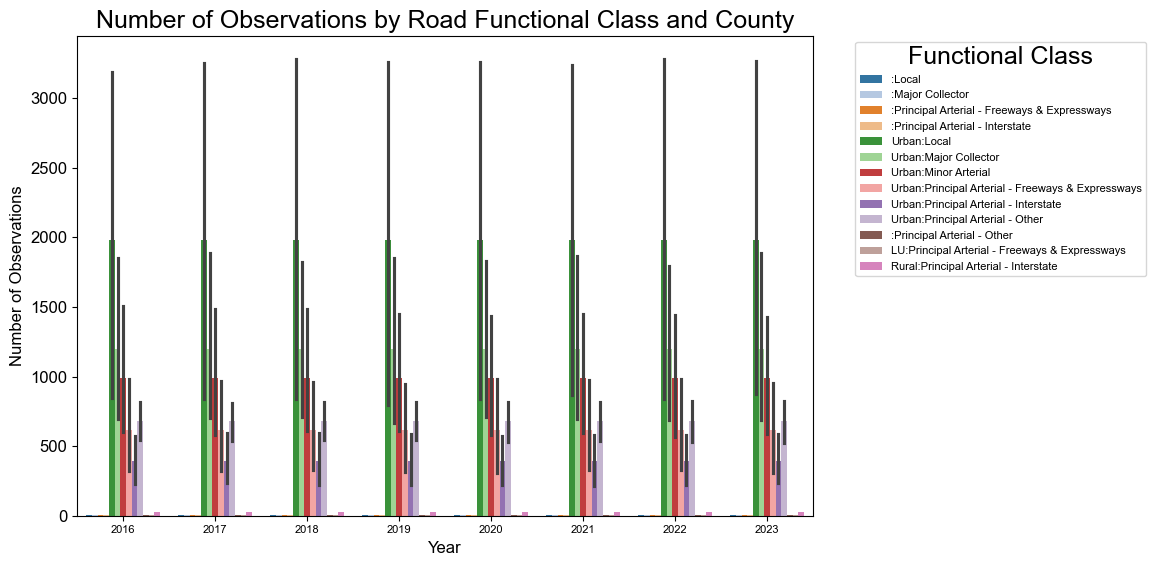

In [199]:
# Set Seaborn color palette
palette = sns.color_palette("tab20")

# UGLY PLOT
plt.figure(figsize=(12, 6))
sns.barplot(
    data=class_cts, x='Year', y='size', 
    hue='Functional Class', palette=palette)
plt.title('Number of Observations by Road Functional Class and County')
plt.xlabel('Year')
plt.ylabel('Number of Observations')
plt.legend(title='Functional Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

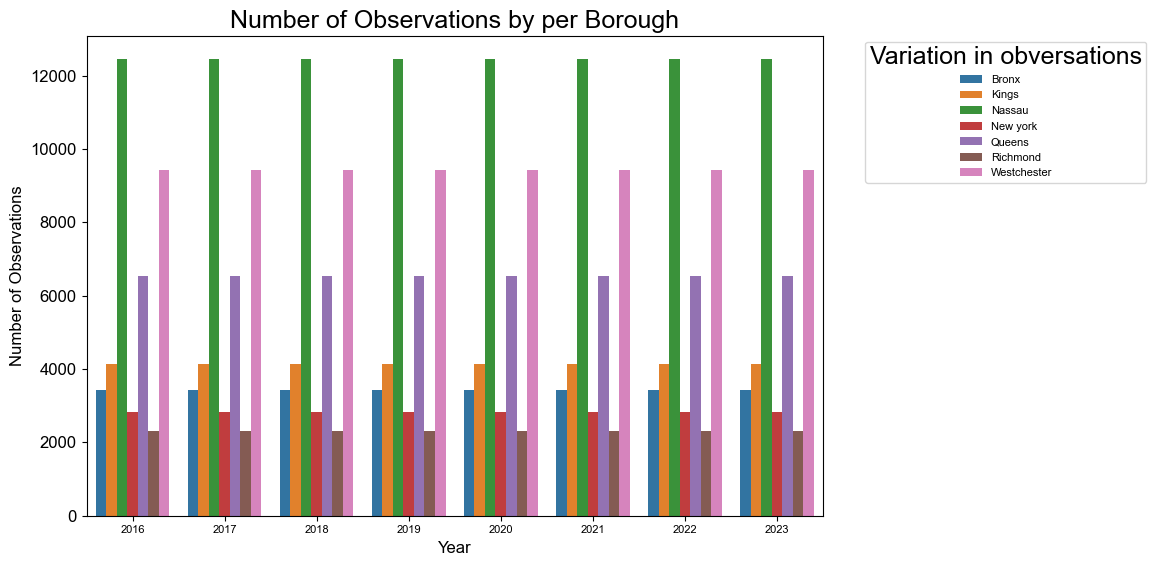

In [211]:
# Where do the most measurements come from?
borough_cts = city_l.groupby(['Year', 'County'], as_index=False).size()
borough_cts.head(2)

# palette = sns.color_palette("tab20")
plt.figure(figsize=(12, 6))
sns.barplot(data=borough_cts, x='Year', y='size', hue='County')
plt.title('Number of Observations by per Borough')
plt.xlabel('Year')
plt.ylabel('Number of Observations')
plt.legend(title='Variation in obversations', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

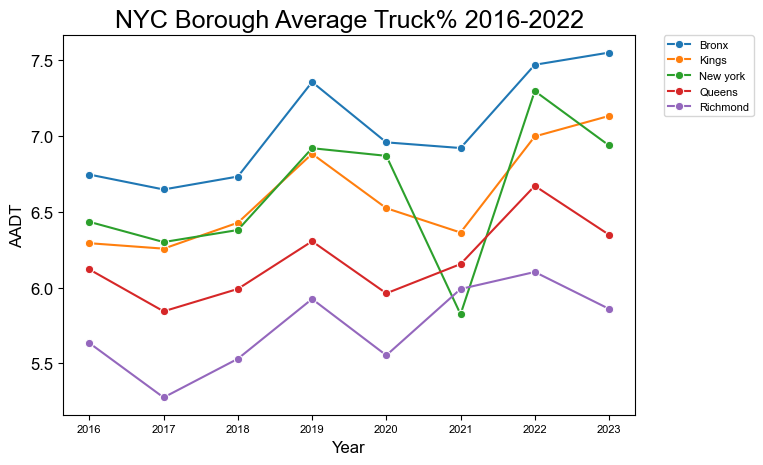

In [229]:
# PLOT TRUCK PCT
plt.figure(figsize=(8,5))
nyc_pivot = city_pivot[city_pivot['County'].isin(['Bronx','Kings', 'New york','Queens', 'Richmond'])]
# Plot a line chart for AADT, grouped by County
sns.lineplot(data=nyc_pivot, x='Year', y='Truck%', hue='County', marker='o', errorbar=None)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('AADT')
plt.title('NYC Borough Average Truck% 2016-2022')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.savefig('Borough_average_truck_traffic.jpeg', format='jpeg', dpi=300)
plt.show()


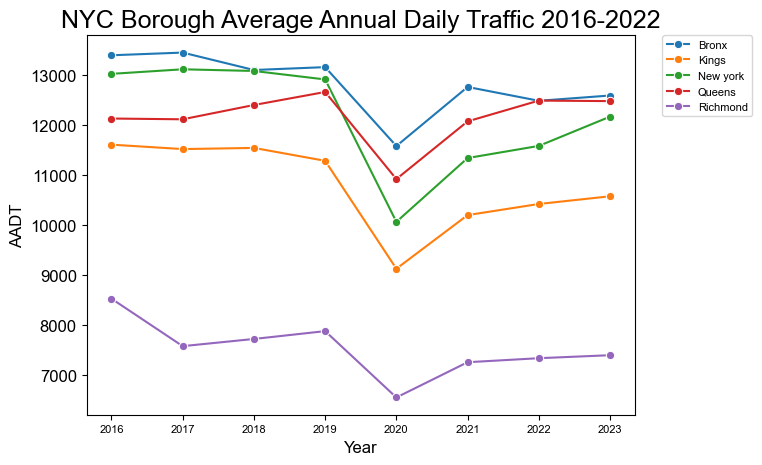

In [225]:
# PLOT AADT
plt.figure(figsize=(8, 5))
nyc_pivot = city_pivot[city_pivot['County'].isin(['Bronx','Kings', 'New york','Queens', 'Richmond'])]
# Plot a line chart for AADT, grouped by County
sns.lineplot(data=nyc_pivot, x='Year', y='AADT', hue='County', marker='o', errorbar=None)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('AADT')
plt.title('NYC Borough Average Annual Daily Traffic 2016-2022')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.savefig('Borough_average_annual_daily_traffic.jpeg', format='jpeg', dpi=300)
plt.show()


In [ ]:
# LETS LOOK AT OVER TIME


# Convert 'year_month' to datetime for plotting
# monthly_counts['year_month'] = pd.to_datetime(monthly_counts['year_month'])
# Plot using Matplotlib

# plt.figure(figsize=(12, 6))
# for category in monthly_counts['Boro'].unique():
#     subset = monthly_counts[monthly_counts['Boro'] == category]
#     plt.plot(subset['year_month'], subset['count'], marker='o', label=category)

# plt.title('Observations per Month by Boro')
# plt.xlabel('Date')
# plt.ylabel('Number of Observations')
# plt.xticks(rotation=45)
# plt.legend(title='Boro')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:
# lets look at 2022 count stats
# alsom coming from this website: https://nysdottrafficdata.drakewell.com/publicmultinodemap.asp
# raw_ct = pd.read_csv("/Users/zoelye/Documents/Brainstation/capstone/Data_traffic/2022_Count_Stats/Export Worksheet-Table 1.csv")

# 